# 🔍 Image Classification with Grad-CAM Visualization

**Fixing a Deprecation Issue in PyTorch Grad-CAM Library**:

In my env, the file path is: miniconda3/envs/my_env/lib/python3.12/site-packages/pytorch_grad_cam/utils/image.py

Problematic Lines:
```python
data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
plt.close(fig=fig)
data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
```

Replacement Code:
```python
buf = fig.canvas.buffer_rgba()
data = np.frombuffer(buf, dtype=np.uint8)
data = data.reshape(fig.canvas.get_width_height()[::-1] + (4,))[:, :, :3]
plt.close(fig=fig)
```

## 📦 Imports and Helpers

In [1]:
import warnings
import numpy as np
import os, json, torch
import matplotlib.pyplot as plt

from PIL import Image
from peft import PeftModel, PeftConfig
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from transformers import AutoImageProcessor, AutoModelForImageClassification

warnings.filterwarnings("ignore")

/home/student01/miniconda3/envs/medical-vision/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 🧠 Model Loading and Utilities

In [2]:
def get_label(model, idx):
    """Get label name from model config."""
    id2label = model.config.id2label
    key = str(idx) if str(idx) in id2label else idx
    return id2label[key]

def load_model(model_path: str):
    """Load model from a direct path to model folder."""
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model path not found: {model_path}")
    
    is_lora_adapter = os.path.exists(os.path.join(model_path, "adapter_config.json"))
    
    if is_lora_adapter:
        peft_cfg = PeftConfig.from_pretrained(model_path)
        
        parent_dir = os.path.dirname(model_path)
        cfg_path = os.path.join(parent_dir, "config.json")
        
        if os.path.exists(cfg_path):
            with open(cfg_path, "r") as f:
                cfg = json.load(f)
            class_names = cfg.get("classes", [])
            num_classes = len(class_names)
        else:
            raise FileNotFoundError(f"Missing config.json in {parent_dir}")
        
        model = AutoModelForImageClassification.from_pretrained(
            peft_cfg.base_model_name_or_path,
            num_labels=num_classes,
            label2id={cls: i for i, cls in enumerate(class_names)},
            id2label={i: cls for i, cls in enumerate(class_names)},
            ignore_mismatched_sizes=True
        )
        model = PeftModel.from_pretrained(model, model_path)
        processor = AutoImageProcessor.from_pretrained(peft_cfg.base_model_name_or_path)
        
        print(f"✅ Loaded LoRA adapter from: {model_path}")
    else:
        model = AutoModelForImageClassification.from_pretrained(model_path)
        processor = AutoImageProcessor.from_pretrained(model_path)
        
        class_names = [model.config.id2label[i] for i in range(len(model.config.id2label))]
        
        print(f"✅ Loaded full model from: {model_path}")
    
    print(f"📊 Classes: {', '.join(class_names)}")
    return model, processor, class_names

class HuggingfaceToTensorModelWrapper(torch.nn.Module):
    """Wrapper to make HF model compatible with GradCAM."""
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def forward(self, x):
        return self.model(x).logits


## 🔥 Grad-CAM Generator

In [3]:
def gradcam_image(model, image, processor):
    """Generate Grad-CAM visualization for an image."""

    inputs = processor(images=image, return_tensors="pt")
    img_tensor = inputs["pixel_values"].squeeze(0)

    with torch.no_grad():
        logits = model(img_tensor.unsqueeze(0)).logits
        probs = torch.softmax(logits, dim=-1)[0].cpu().numpy()

    top_idx = int(np.argmax(probs))
    top_label = get_label(model, top_idx)
    top_prob = probs[top_idx]

    is_peft = isinstance(model, PeftModel)

    if is_peft:
        base = model.base_model.model
        target_layer = base.mobilevit.conv_1x1_exp
    else:
        target_layer = model.mobilevit.conv_1x1_exp

    model.train()
    img_tensor.requires_grad = True
    targets = [ClassifierOutputTarget(top_idx)]

    try:
        with GradCAM(
            model=HuggingfaceToTensorModelWrapper(model),
            target_layers=[target_layer]
        ) as cam:
            grayscale_cam = cam(input_tensor=img_tensor.unsqueeze(0), targets=targets)[0, :]
    finally:
        model.eval()

    rgb_img = np.float32(image.resize((256, 256))) / 255.0
    grad_img = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    
    return grad_img, probs, top_label, top_prob


## 🔧 Prediction Function

In [4]:
def run_prediction(model_path, image_path):
    """Run prediction with Grad-CAM visualization."""
    print("="*80)
    print("🔍 Running Prediction with Grad-CAM")
    print("="*80)
    
    model, processor, class_names = load_model(model_path)
    model.eval()

    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image not found: {image_path}")
    
    image = Image.open(image_path).convert("RGB")
    print(f"📷 Image: {os.path.basename(image_path)}")
    print(f"   Size: {image.size}")

    print("🔥 Generating Grad-CAM...")
    grad_img, probs, label, prob = gradcam_image(model, image, processor)

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    ax[0].imshow(image)
    ax[0].set_title("Original Image", fontsize=12, fontweight='bold')
    ax[0].axis("off")

    ax[1].imshow(grad_img)
    ax[1].set_title(f"Grad-CAM: {label} ({prob*100:.2f}%)", fontsize=12, fontweight='bold')
    ax[1].axis("off")

    legend_text = " | ".join([f"{cls}: {p*100:.2f}%" for cls, p in zip(class_names, probs)])
    plt.figtext(0.5, 0.02, legend_text, ha="center", fontsize=10, style='italic')

    plt.tight_layout(rect=[0, 0.08, 1, 1])
    plt.show()
    
    print("="*80)
    print(f"✅ Prediction: {label} ({prob*100:.2f}%)")
    print("="*80)


## 🚀 Run Prediction + Visualization

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


🔍 Running Prediction with Grad-CAM
✅ Loaded full model from: outputs/mobilevit-small_lora_20251009_020229/model
📊 Classes: glioma, meningioma, no_tumor, pituitary
📷 Image: brisc2025_test_00540_me_sa_t1.jpg
   Size: (224, 224)
🔥 Generating Grad-CAM...


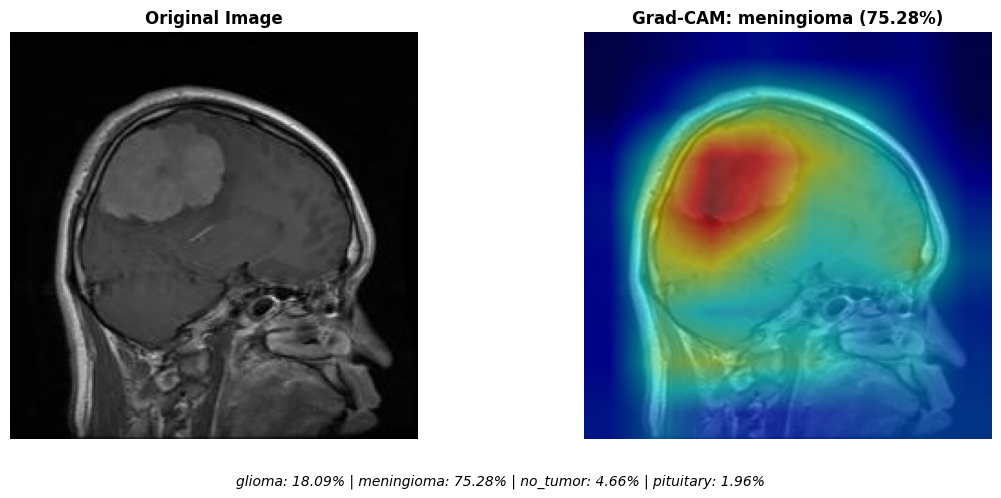

✅ Prediction: meningioma (75.28%)


In [5]:
# 🧠 Brain Tumor Classification
model_path = "outputs/mobilevit-small_lora_20251009_020229/model"
image_path = "Data/brain_tumor/test/meningioma/brisc2025_test_00540_me_sa_t1.jpg"

run_prediction(model_path, image_path)

🔍 Running Prediction with Grad-CAM
✅ Loaded full model from: outputs/mobilevit-small_lora_20251009_020356/model
📊 Classes: COVID19, NORMAL, PNEUMONIA, TURBERCULOSIS
📷 Image: person3_virus_17.jpg
   Size: (224, 224)
🔥 Generating Grad-CAM...


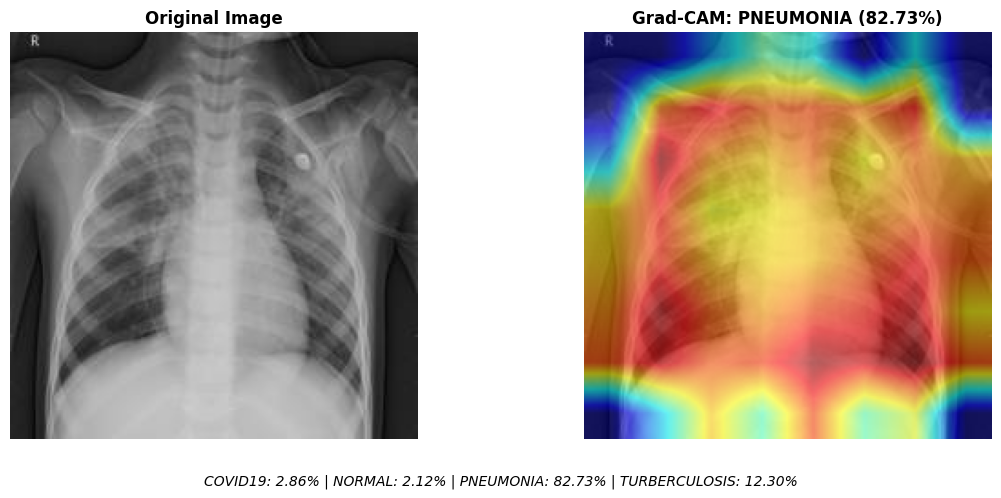

✅ Prediction: PNEUMONIA (82.73%)


In [6]:
# 🫁 Chest X-Ray Classification
model_path = "outputs/mobilevit-small_lora_20251009_020356/model"
image_path = "Data/chest-xray/test/PNEUMONIA/person3_virus_17.jpg"

run_prediction(model_path, image_path)

🔍 Running Prediction with Grad-CAM
✅ Loaded full model from: outputs/mobilevit-small_lora_20251009_020455/model
📊 Classes: adenocarcinoma, benign, squamous_cell_carcinoma
📷 Image: 0024.jpg
   Size: (224, 224)
🔥 Generating Grad-CAM...


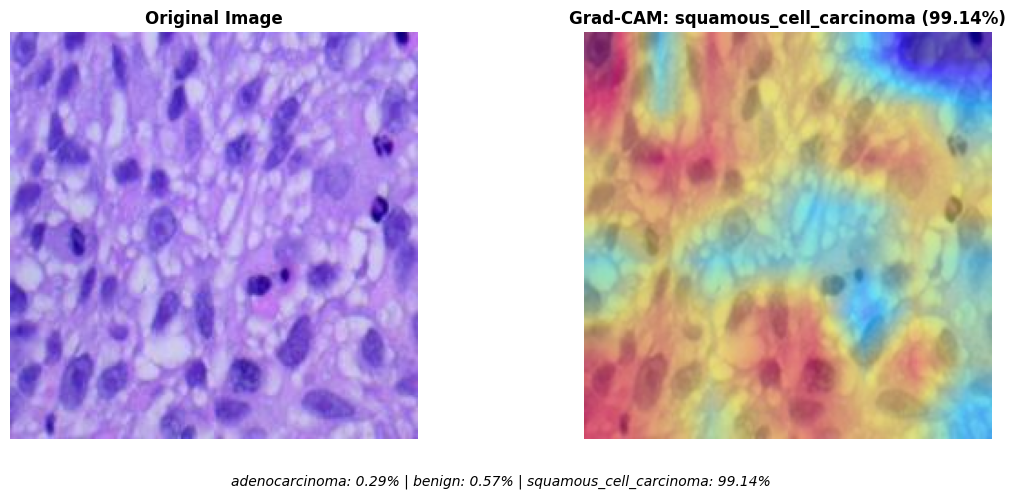

✅ Prediction: squamous_cell_carcinoma (99.14%)


In [7]:
# 🔬 Lung Cancer Histopathology Classification
model_path = "outputs/mobilevit-small_lora_20251009_020455/model"
image_path = "Data/lung-cancer/test/squamous_cell_carcinoma/0024.jpg"

run_prediction(model_path, image_path)